# Interpolation of Sea Level Anomaly using GPSat


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SLA Interpolation

Now, the data is all set and we can proceed with the interpolation.

In [2]:
! pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.9 MB/s eta 0:00:00


In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Define the transformation function
def WGS84toEASE2_Vectorized(lon, lat, return_vals="both", lon_0=0, lat_0=-90):
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y
def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=-90):

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat

def get_projection(projection=None):

    # projection
    if projection is None:
        projection = ccrs.NorthPolarStereo()
    elif isinstance(projection, ccrs.Projection):
        pass
    elif isinstance(projection, str):
        if re.search("north", projection, re.IGNORECASE):
            projection = ccrs.NorthPolarStereo()
        elif re.search("south", projection, re.IGNORECASE):
            projection = ccrs.SouthPolarStereo()
        else:
            raise NotImplementedError(f"projection provide as str: {projection}, not implemented")

    return projection
def plot_pcolormesh(ax, lon, lat, plot_data,
                    fig=None,
                    title=None,
                    vmin=None,
                    vmax=None,
                    qvmin=None,
                    qvmax=None,
                    cmap='YlGnBu_r',
                    cbar_label=None,
                    scatter=False,
                    extent=None,
                    ocean_only=False,
                    **scatter_args):

    # ax = axs[j]
    ax.coastlines(resolution='50m', color='white')
    ax.add_feature(cfeat.LAKES, color='white', alpha=.5)
    ax.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))
    # extent=[10, -150, -80, -67] if extent is None else extent
    extent = [-180, 180, 60, 90] if extent is None else extent
    ax.set_extent(extent, ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

    if title:
        ax.set_title(title)

    if ocean_only:
        if globe_mask is None:
            warnings.warn(f"ocean_only={ocean_only}, however globe_mask is missing, "
                          f"install with pip install global-land-mask")
        else:
            is_in_ocean = globe_mask.is_ocean(lat, lon)
            # copy, just to be safe
            plot_data = copy.copy(plot_data)
            plot_data[~is_in_ocean] = np.nan

    if qvmin is not None:
        if vmin is not None:
            warnings.warn("both qvmin and vmin are supplied, only using qvmin")
        assert (qvmin >= 0) & (qvmin <= 1.0), f"qvmin: {qvmin}, needs to be in [0,1]"
        vmin = np.nanquantile(plot_data, q=qvmin)

    if qvmax is not None:
        if vmax is not None:
            warnings.warn("both qvmax and vmax are supplied, only using qvmax")
        assert (qvmax >= 0) & (qvmax <= 1.0), f"qvmax: {qvmax}, needs to be in [0,1]"
        vmax = np.nanquantile(plot_data, q=qvmax)

    if (vmin is not None) & (vmax is not None):
        assert vmin <= vmax, f"vmin: {vmin} > vmax: {vmax}"

    if not scatter:
        s = ax.pcolormesh(lon, lat, plot_data,
                          cmap=cmap,
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree(),
                          linewidth=0,
                          shading="auto",# to remove DeprecationWarning
                          rasterized=True)
    else:
        non_nan = ~np.isnan(plot_data)
        s = ax.scatter(lon[non_nan],
                       lat[non_nan],
                       c=plot_data[non_nan],
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(),
                       linewidth=0,
                       rasterized=True,
                       **scatter_args)

    if fig is not None:
        cbar = fig.colorbar(s, ax=ax, orientation='horizontal', pad=0.03, fraction=0.03)
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=14)
        cbar.ax.tick_params(labelsize=14)


With a collection of 16 files, it's essential to streamline the aforementioned process. Doing so will enable us to amalgamate the individual files into a comprehensive dataframe, forming an extensive dataset for thorough examination. We've done the processing for you and you just need to load it in using the code below.

These are the native files that the data is originally from:

SEN3_files = [
    "S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T121326_20230105T122007_20230105T134843_0401_094_080______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T184910_20230105T185308_20230105T202752_0238_094_084______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230106T182316_20230106T182702_20230106T200253_0226_094_098______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230109T120945_20230109T121625_20230109T135020_0400_094_137______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T122257_20230107T122931_20230107T135514_0394_074_351______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T185833_20230107T190234_20230107T203555_0240_074_355______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T183238_20230108T183630_20230108T200807_0232_074_369______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T115654_20230108T120333_20230108T133905_0399_074_365______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T185450_20230111T185850_20230111T202939_0240_075_027______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T121911_20230111T122547_20230111T135219_0396_075_023______MAR_O_NR_005.SEN3"
]

In [5]:
import pandas as pd

# savepath = '/Users/wg4031/Downloads/'
savepath = '/content/drive/MyDrive/GEOL0069/2324/Week 8 2025/'

# Load DataFrame from CSV file
# df = pd.read_csv(savepath+'all_data_01.csv')
df = pd.read_csv(savepath+'all_data_20.csv')

Now we proceed with GPSat, with the same process we went through in week 7.

In [7]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

Cloning into 'GPSat'...
remote: Enumerating objects: 2873, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2873 (delta 143), reused 253 (delta 139), pack-reused 2601 (from 1)
Receiving objects: 100% (2873/2873), 59.92 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
changing directory to: /content/GPSat


In [8]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requireme

In [9]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat


In [10]:
pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [11]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d
import cartopy.crs as ccrs
import cartopy.feature as cfeat

In [6]:
df

,x,y,t,obs
0,-1.158352e+06,-2.326781e+06,19358.786713,0.00040
1,-1.153165e+06,-2.322564e+06,19358.786725,-0.00385
2,-1.147980e+06,-2.318345e+06,19358.786736,-0.00705
3,-1.142795e+06,-2.314125e+06,19358.786748,-0.00705
4,-1.137610e+06,-2.309902e+06,19358.786759,-0.00675
...,...,...,...,...
4946,1.307158e+06,-3.217842e+06,19368.517847,0.01555
4947,1.311551e+06,-3.222704e+06,19368.517859,0.03775
4948,1.315944e+06,-3.227565e+06,19368.517870,0.10420
4949,1.320338e+06,-3.232424e+06,19368.517882,0.13745


In [12]:
x_Eddy, y_Eddy = WGS84toEASE2_New(lon=-171.5, lat=-77,lat_0=-90)

<ipython-input-12-571f612af049>:1: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  x_Eddy, y_Eddy = WGS84toEASE2_New(lon=-171.5, lat=-77,lat_0=-90)


In [ ]:
# plt.scatter(df['lon'][df['lon']<-150][df['lat']<-72],df['lat'][df['lon']<-150][df['lat']<-72])
# plt.scatter(-171.5, -77, marker = 'x', color='red')

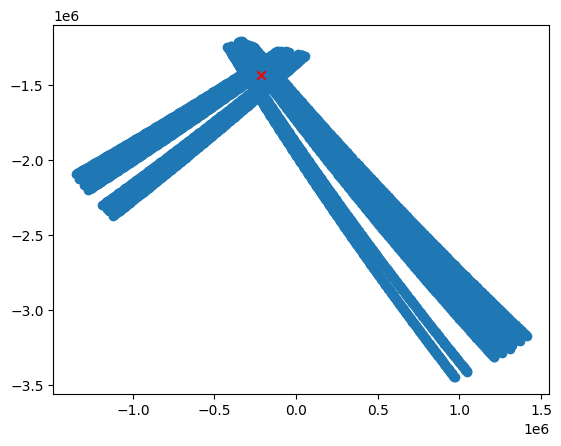

In [13]:
plt.scatter(df['x'],df['y'])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

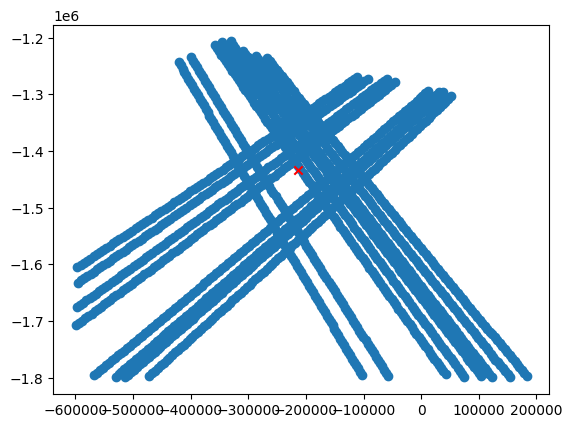

In [14]:
# condition=[df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0]
plt.scatter(df['x'][df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0],df['y'][df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

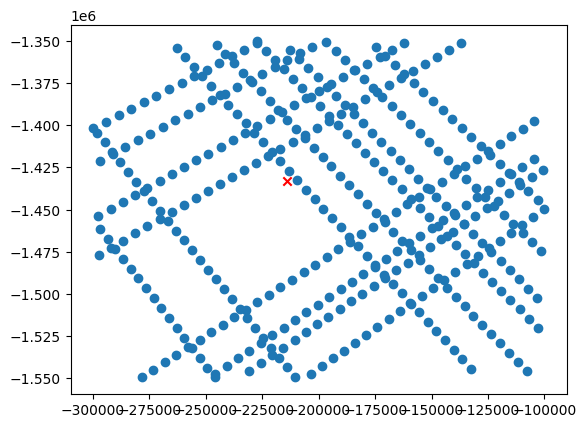

In [15]:
# condition=[df['x']<200000.0][df['x']>-600000.0][df['y']<-1000000.0][df['y']>-1800000.0]
plt.scatter(df['x'][df['x']<-100000.0][df['x']>-300000.0][df['y']<-1350000.0][df['y']>-1550000.0],df['y'][df['x']<-100000.0][df['x']>-300000.0][df['y']<-1350000.0][df['y']>-1550000.0])
plt.scatter(x_Eddy, y_Eddy, marker = 'x', color='red')

In [ ]:
df['t']

0       19358.786713
1       19358.786725
2       19358.786736
3       19358.786748
4       19358.786759
            ...     
3104    19368.517859
3105    19368.517870
3106    19368.517882
3107    19368.517894
3108    19368.517905
Name: t, Length: 3109, dtype: float64

In [16]:
# - spaced every 10km for some x,y range
# xy_grid = grid_2d_flatten(x_range=[-600000.0, 200000.0],
#                           y_range=[-1800000.0, -1000000.0],
#                           step_size=100_000)
xy_grid = grid_2d_flatten(x_range=[-300000.0, -100000.0],
                          y_range=[-1550000.0, -1350000.0],
                          step_size=20_000)



# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

Local expert locations:


,x,y,t
0,-290000.0,-1540000.0,19363.0
1,-270000.0,-1540000.0,19363.0
2,-250000.0,-1540000.0,19363.0
3,-230000.0,-1540000.0,19363.0
4,-210000.0,-1540000.0,19363.0


<ipython-input-19-2db4156885dd>:3: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'],lat_0=-90)


'plot_pcolormesh': 0.013 seconds
'plot_pcolormesh': 0.058 seconds


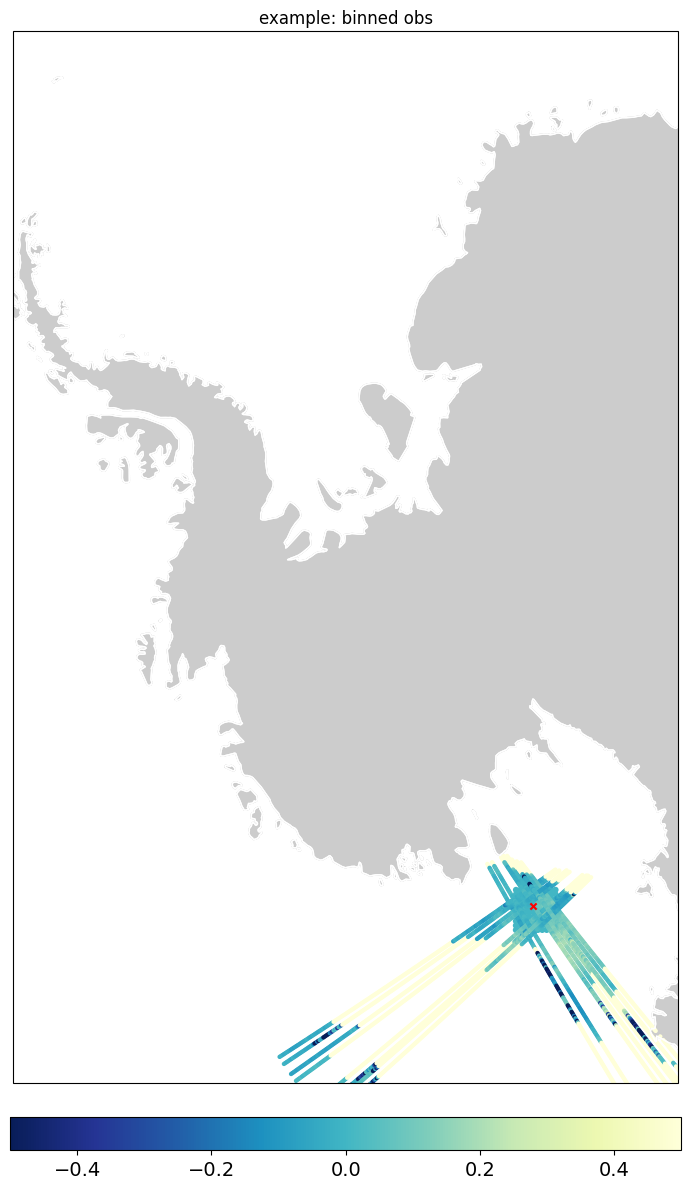

In [19]:
# plot expert locations
df['lon'], df['lat'] = EASE2toWGS84(df['x'], df['y'])
eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'],lat_0=-90)


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=0*eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plot_pcolormesh(ax=ax,
                lon=df['lon'],
                lat=df['lat'],
                plot_data=df['obs'],
                title="example: binned obs",
                scatter=True,
                s=10,
                fig=fig,
                # extent=[-180, 180, -90, -60],
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plt.scatter(x=-171.5, y=-77, s=20, marker='x', color='red', transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [20]:
# - spaced every 5km


# xy_grid = grid_2d_flatten(x_range=[-600000.0, 200000.0],
#                           y_range=[-1800000.0, -1000000.0],
#                           step_size=10_000)

xy_grid = grid_2d_flatten(x_range=[-300000.0, -100000.0],
                          y_range=[-1550000.0, -1350000.0],
                          step_size=5_000)


# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# Add lon-lat measurements
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'], lat_0=-90)

print("Prediction locations:")
ploc

Prediction locations:


<ipython-input-20-ddfe51deed04>:19: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'], lat_0=-90)


,x,y,lon,lat
0,-297500.0,-1547500.0,-169.117906,-75.852711
1,-292500.0,-1547500.0,-169.296538,-75.861163
2,-287500.0,-1547500.0,-169.475381,-75.869477
3,-282500.0,-1547500.0,-169.654432,-75.877652
4,-277500.0,-1547500.0,-169.833687,-75.885688
...,...,...,...,...
1595,-122500.0,-1352500.0,-174.824670,-77.816683
1596,-117500.0,-1352500.0,-175.034829,-77.820664
1597,-112500.0,-1352500.0,-175.245123,-77.824480
1598,-107500.0,-1352500.0,-175.455545,-77.828131


In [21]:
# Set training and inference radius
training_radius = 100_000   # 300km
inference_radius = 50_000  # 200km

# Local expert locations config
local_expert = ExpertLocsConfig(source = eloc)

# Model config
# model = ModelConfig(oi_model = "GPflowSVGPModel", # Use GPflow SVGP model
model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates by 50km
                        "coords_scale": [10_000, 10_000, 1]
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )

# Data config
data = DataConfig(data_source = df,
                  obs_col = "obs",
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within 300km and ± 4 days of the expert location
                    {"col": "t", "comp": "<=", "val": 4},
                    {"col": "t", "comp": ">=", "val": -4},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = ploc,
                                max_dist = inference_radius)


In [22]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)


'data_select': 0.000 seconds
'load': 0.000 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 4951 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 1600 >  100
storing as str


In [23]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path)

---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 100
current local expert:
          x          y        t         lon        lat
0 -290000.0 -1540000.0  19363.0 -169.335424 -75.931873
'data_select': 0.000 seconds
'load': 0.000 seconds
'local_data_select': 0.004 seconds
number obs: 147
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 3.182 seconds
'get_parameters': 0.010 seconds
'set_lengthscales_constraints': 0.013 seconds
**********
optimization failed!
'optimise_parameters': 4.931 seconds
'get_parameters': 0.015 seconds
parameters:
lengthscales: array([1.e-12, 6.e+01, 1.e-08]) 
kernel_variance: 7801356.356427869
likelihood_variance: 7096984.216863724
'predict': 0.135

In [24]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [25]:
dfs.keys()

dict_keys(['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details'])

In [26]:
dfs['lengthscales']

,x,y,t,_dim_0,lengthscales,lon,lat
0,-290000.0,-1540000.0,19363.0,0,1.000000e-12,-169.335424,-75.931873
1,-290000.0,-1540000.0,19363.0,1,6.000000e+01,-169.335424,-75.931873
2,-290000.0,-1540000.0,19363.0,2,1.000000e-08,-169.335424,-75.931873
3,-270000.0,-1540000.0,19363.0,0,2.773321e+00,-170.055706,-75.964166
4,-270000.0,-1540000.0,19363.0,1,1.612632e+00,-170.055706,-75.964166
...,...,...,...,...,...,...,...
295,-130000.0,-1360000.0,19363.0,1,6.000000e+01,-174.539787,-77.743150
296,-130000.0,-1360000.0,19363.0,2,9.000000e+00,-174.539787,-77.743150
297,-110000.0,-1360000.0,19363.0,0,5.683318e+01,-175.375849,-77.758986
298,-110000.0,-1360000.0,19363.0,1,2.135371e-01,-175.375849,-77.758986


In [27]:
preds_data = dfs["preds"]
preds_data.head()

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()


,pred_loc_x,pred_loc_y,f*,f*_var
0,-297500.0,-1547500.0,0.001225,4.658899e+06
1,-297500.0,-1542500.0,0.002226,4.219413e+06
2,-297500.0,-1537500.0,0.005016,3.657230e+06
3,-297500.0,-1532500.0,0.008267,3.038105e+06
4,-297500.0,-1527500.0,0.013497,2.391145e+06


<ipython-input-28-9edd7b7919e0>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
<ipython-input-28-9edd7b7919e0>:3: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
<ipython-input-28-9edd7b7919e0>:4: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
<ipython-input-28-9edd7b7919e0>:5: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` 

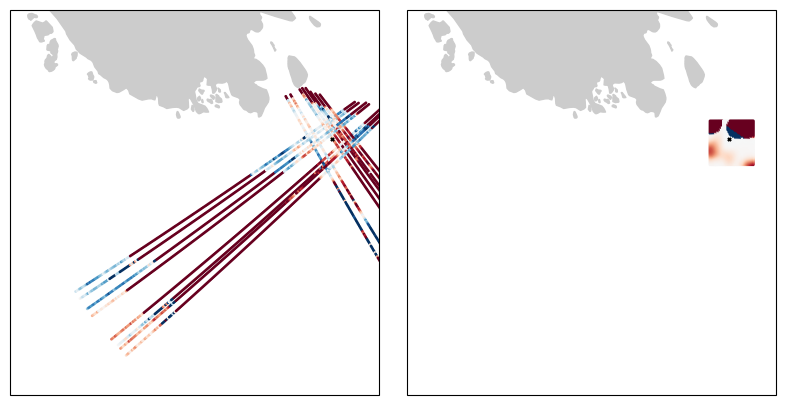

In [28]:
#inference 50 radius 100 loc 20km
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

<ipython-input-42-dd9df13b3a26>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
<ipython-input-42-dd9df13b3a26>:3: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
<ipython-input-42-dd9df13b3a26>:4: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
<ipython-input-42-dd9df13b3a26>:5: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` 

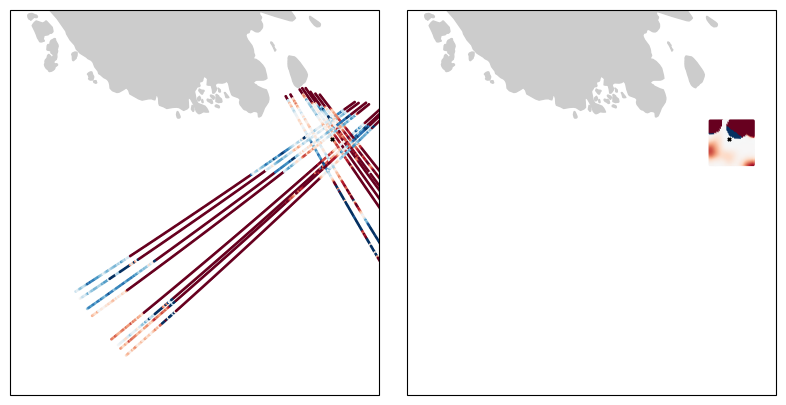

In [42]:
#inference 100 radius 300 loc 40km
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

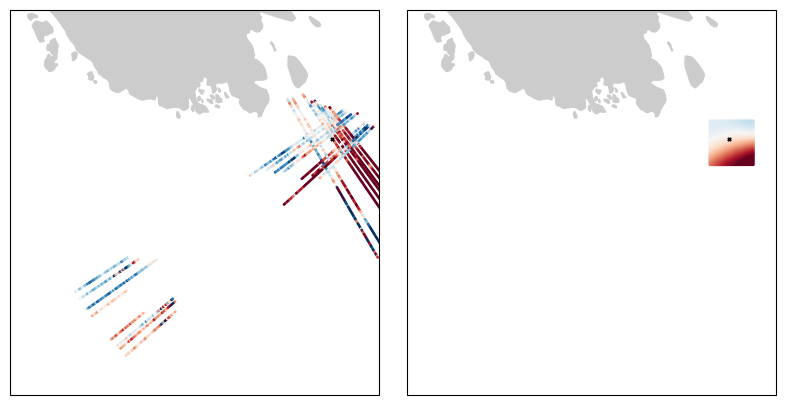

In [ ]:
eddylon,eddylat = EASE2toWGS84_New(x_Eddy,y_Eddy,lat_0=-90)
eloc['lon'],eloc['lat'] = EASE2toWGS84_New(eloc['x'],eloc['y'],lat_0=-90)
ploc['lon'],ploc['lat'] = EASE2toWGS84_New(ploc['x'],ploc['y'],lat_0=-90)
df['lon'],df['lat'] = EASE2toWGS84_New(df['x'],df['y'],lat_0=-90)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)

fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-140, -180, -80, -67],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND,color=(0.8,0.8,0.8))
    #ax.scatter(eloc['lon'],eloc['lat'],s=1,color='r',transform=ccrs.PlateCarree())
    #ax.scatter(ploc['lon'],ploc['lat'],s=1,color='b',transform=ccrs.PlateCarree())
    if c == 0:
        ax[c].scatter(df['lon'],df['lat'],c=df['obs'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='RdBu_r',vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree())
    ax[c].scatter(eddylon,eddylat,s=5,color='k',transform=ccrs.PlateCarree(),marker='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
plt_data.shape

(1600, 4)

In [ ]:
x_grid=np.asarray(plt_data['pred_loc_x']).reshape(40,40,order='C')
y_grid=np.asarray(plt_data['pred_loc_y']).reshape(40,40,order='C')
z_grid=np.asarray(plt_data['f*']).reshape(40,40,order='C')
v_grid=np.asarray(plt_data['f*_var']).reshape(40,40)

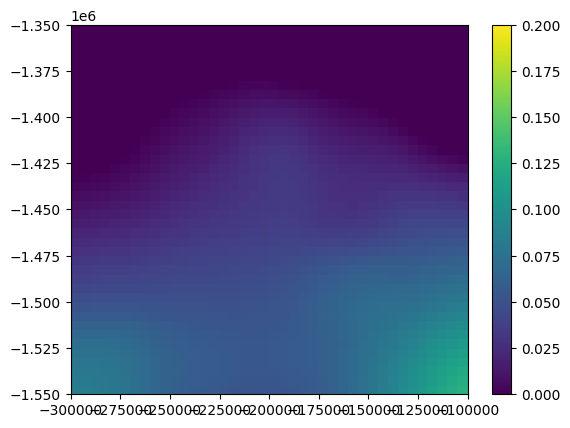

In [ ]:
#inference 50 radius 100 loc 20km
plt.pcolor(x_grid,y_grid,z_grid,vmin=0,vmax=0.2)
plt.colorbar()

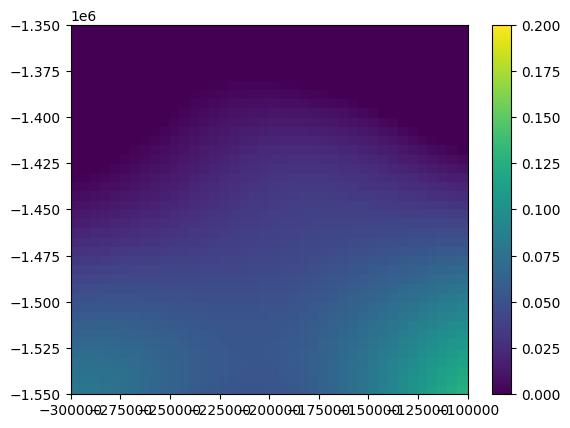

In [ ]:
#inference 100 radius 300 loc 40km
plt.pcolor(x_grid,y_grid,z_grid,vmin=0,vmax=0.2)
plt.colorbar()

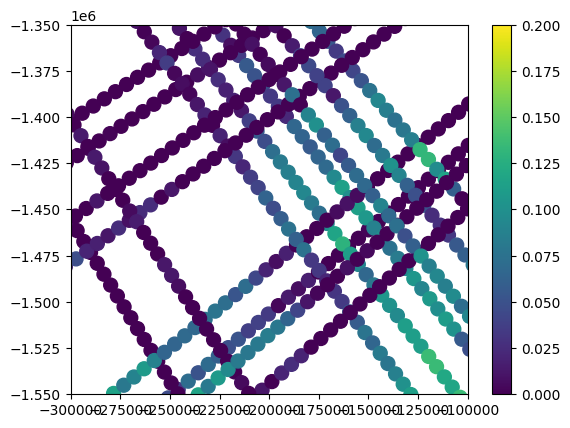

In [29]:
plt.scatter(df['x'], df['y'], c=df['obs'], s=100, vmin=0, vmax=0.2)  # 'obs' as both color and size
plt.xlim((-300000.0, -100000.0))
plt.ylim((-1550000.0, -1350000.0))
plt.colorbar()  # Add colorbar to show the mapping of 'obs' values to colors
plt.show()

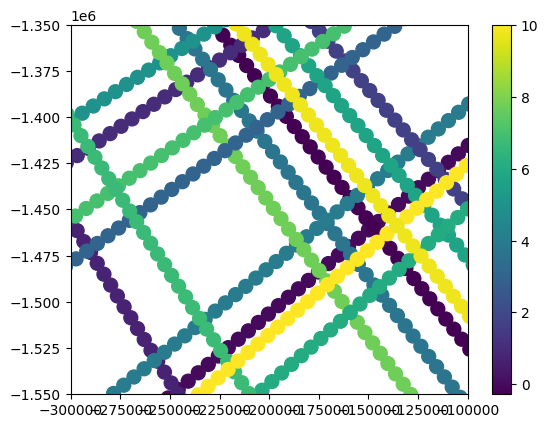

In [30]:
plt.scatter(df['x'], df['y'], c=df['t']-19358.786713, s=100)#, vmin=0, vmax=0.2)  # 'obs' as both color and size
plt.xlim((-300000.0, -100000.0))
plt.ylim((-1550000.0, -1350000.0))
plt.colorbar()  # Add colorbar to show the mapping of 'obs' values to colors
plt.show()